In [ ]:
#|default_exp benchmarking.zhang_principal_curvature
import numpy as np

In [ ]:
#|export
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import torch
import pandas as pd
from sklearn.neighbors import NearestNeighbors
from tqdm import tqdm
import pandas as pd
import skdim
from scipy.stats import pearsonr
from sklearn.metrics import mean_squared_error
def epsilon_and_tau(point_cloud, query):
    ratio_all = []
    nbrs = NearestNeighbors(n_neighbors=2500, algorithm='ball_tree').fit(point_cloud)
    for i in range(1, 200):
        epsilon_PCA = 0.01 * i 
        ep_dist, ep_idx = nbrs.radius_neighbors(query, epsilon_PCA, return_distance=True, sort_results = True)

        pca_nbrs = point_cloud[ep_idx[0]]
        Xi = pca_nbrs - query
        Di = np.diag(np.sqrt(np.exp(-1*np.array(ep_dist[0]) ** 2 / epsilon_PCA)))
        Bi = Xi.T @ Di
    
        U, S, VT = np.linalg.svd(Bi.T, full_matrices = True)
        if len(S)>= 2: 
            ratio = (S[0]+ S[1])/sum(S)
        else:
            ratio = 1.0
        ratio_all.append(ratio)
    tau = 0.01 * np.argmin(np.array(ratio_all) - min(ratio_all))
    eps_PCA = 0.01 * np.argmin(np.abs(np.array(ratio_all) - 0.85))
    return eps_PCA, tau
def Gaussian_Curvature_2d(point_cloud, query_point,  intrin_dim = 2, epsilon_PCA = 0.1, tau_radius = 0.4, 
                          prpl_percent = 0.5, use_heuristic = False):
    #point_cloud: the manifold 
    #x: np.array of shape 1 by p, the point where the curvature is evaluated at, e.g., [[1, 2, 3]]
    #epsilon: the radius of local PCA
    #dim: the dimension of the manifold
    #tau_ratio: the ratio is tau radius (where we evaluate the curvature)/ epsilon_sqrt
    
    # Find transport neighborhood
    k = int(0.2 * point_cloud.shape[0])
    
    if use_heuristic: 
        epsilon_PCA, tau_radius = epsilon_and_tau(point_cloud, query_point)
    else:
        pass
        

    nbrs = NearestNeighbors(n_neighbors=k, algorithm='ball_tree').fit(point_cloud)
    
    ep_dist, ep_idx = nbrs.radius_neighbors(query_point, epsilon_PCA, return_distance=True, sort_results = True)
    
    tau_dist, tau_idx = nbrs.radius_neighbors(query_point, tau_radius, return_distance=True, sort_results = True)
    
    tau_nbrs = point_cloud[tau_idx[0]]
    
    pca_nbrs = point_cloud[ep_idx[0]]
    Xi = pca_nbrs - query_point
    Di = np.diag(np.sqrt(np.exp(- np.array(ep_dist[0]) ** 2 / epsilon_PCA)))
    # print("di", Di.shape, "ep dist", ep_dist)
    Bi = Xi.T @ Di

    # print("Bi", Bi.shape)
    U, S, VT = np.linalg.svd(Bi.T, full_matrices = False)
    # print("vt", VT.shape)
    O = VT
    
    tau_nbrs_new = tau_nbrs[1:]
    tau_dist_new = tau_dist[0][1:]
    
    O2 = np.cross(O[0], O[1])

    ti = tau_nbrs_new - query_point[0]
    norms = np.square(ti).sum(axis=1)
    tensor_all = 2 * (O2 * ti).sum(axis=1) / norms
    
    
    max_min_num = int(prpl_percent * len(tau_nbrs_new))
    
    max_indices = np.argsort(tensor_all)[-max_min_num: ]
    max_cur = tensor_all[max_indices]
    
    min_indices = np.argsort(tensor_all)[:max_min_num]
    min_cur = tensor_all[min_indices]
    
    max_cur_weight = np.sqrt(np.exp(-1 * np.array(tau_dist_new[max_indices]) ** 2 / np.sqrt(tau_radius)))
    min_cur_weight = np.sqrt(np.exp(-1 * np.array(tau_dist_new[min_indices]) ** 2 / np.sqrt(tau_radius)))

    stability_epsilon = 0
    if sum(max_cur_weight) == 0 or sum(min_cur_weight) == 0: stability_epsilon = 1e-8
    principal_cur1 = sum(max_cur_weight * max_cur)/(sum(max_cur_weight) + stability_epsilon)
    principal_cur2 = sum(min_cur_weight * min_cur)/(sum(min_cur_weight) + stability_epsilon)
      
    return principal_cur1 * principal_cur2
    

In [ ]:
def Gaussian_Curvature_High(point_cloud, query_point,  intrin_dim = 2, epsilon_PCA = 0.1, tau_radius = 0.4, 
                            prpl_percent = 0.5, use_cross = True, use_heuristic = False):
    #point_cloud: the manifold 
    #x: np.array of shape 1 by p, the point where the curvature is evaluated at, e.g., [[1, 2, 3]]
    #epsilon: the radius of local PCA
    #dim: the dimension of the manifold
    #tau_ratio: the ratio is tau radius (where we evaluate the curvature)/ epsilon_sqrt
    
    # Find transport neighborhood
    k = int(0.2 * point_cloud.shape[0])
    
    if use_heuristic: 
        epsilon_PCA, tau_radius = epsilon_and_tau(point_cloud, query_point)
    else:
        pass
        

    nbrs = NearestNeighbors(n_neighbors=k, algorithm='ball_tree').fit(point_cloud)
    ep_dist, ep_idx = nbrs.radius_neighbors(query_point, epsilon_PCA, return_distance=True, sort_results = True)
    
    tau_dist, tau_idx = nbrs.radius_neighbors(query_point, tau_radius, return_distance=True, sort_results = True)
    
    tau_nbrs = point_cloud[tau_idx[0]]
    
    pca_nbrs = point_cloud[ep_idx[0]]
    Xi = pca_nbrs - query_point
    Di = np.diag(np.sqrt(np.exp(- np.array(ep_dist[0]) ** 2 / epsilon_PCA)))
    Bi = Xi.T @ Di
    
    U, S, VT = np.linalg.svd(Bi.T, full_matrices = False)
    O = VT
    
    tau_nbrs_new = tau_nbrs[1:]
    tau_dist_new = tau_dist[0][1:]
    
    cur = []
    for k in range(2, intrin_dim + 1):
        O2 = O[k, :3]
        ti = tau_nbrs_new[:, k-2: k+1] - query_point[0, k-2: k+1]
        norms = np.square(ti).sum(axis=1)
        tensor_all = 2 * (O2 * ti).sum(axis=1) / norms
    
    
        max_min_num = int(prpl_percent * len(tau_nbrs_new))
        max_indices = np.argsort(tensor_all)[-max_min_num: ]
        max_cur = tensor_all[max_indices]
    
        min_indices = np.argsort(tensor_all)[:max_min_num]
        min_cur = tensor_all[min_indices]
    
        max_cur_weight = np.sqrt(np.exp(-1 * np.array(tau_dist_new[max_indices]) ** 2 / np.sqrt(tau_radius)))
        min_cur_weight = np.sqrt(np.exp(-1 * np.array(tau_dist_new[min_indices]) ** 2 / np.sqrt(tau_radius)))
    
        principal_cur1 = sum(max_cur_weight * max_cur)/sum(max_cur_weight)
        principal_cur2 = sum(min_cur_weight * min_cur)/sum(min_cur_weight)
        cur.append(principal_cur1 * principal_cur2)
      
    return sum(cur)

In [ ]:
#|export
def adalpca_curvature_of_point_cloud(X, use_heuristic=True, eps_PCA = 1, tau_radius = 1.5, master_progress_bar = None):
    curvature = []
    num_eval = len(X)
    i_s = list(range(len(X)))
    pb = progress_bar(i_s, parent = master_progress_bar)
        
    # curvature = parallel(curv_fn, i_s , n_workers=10, progress=pb)
    for i in pb:
        try:
            b = Gaussian_Curvature_2d(X, X[i].reshape(1, -1), prpl_percent = 0.3, use_heuristic = use_heuristic, epsilon_PCA = epsilon_PCA, tau_radius = tau_radius)
        except IndexError: # the point we're computing the curvature of is too far away from everything.
            b = 0
        curvature.append(b)
        
    ks_computed = np.array(curvature)
    return ks_computed

In [ ]:
def adalpca_curvature_of_point(X, idx, use_heuristic=True, eps_PCA = 1, tau_radius = 1.5):
    try:
        b = Gaussian_Curvature_2d(X, X[i].reshape(1, -1), prpl_percent = 0.3, use_heuristic = use_heuristic, epsilon_PCA = epsilon_PCA, tau_radius = tau_radius)
    except IndexError: # the point we're computing the curvature of is too far away from everything.
        b = 0

Saddle Sphere experiments

In [ ]:
from diffusion_curvature.sadspheres import SadSpheres

In [ ]:
use_heuristic = True
epsilon_PCA = 1
tau_radius = 1.5

dim = [2,3,4]
SS1 = SadSpheres(
    dimension = dim, # Dimension of saddles and spheres
    num_pointclouds = 30, # num pointclouds to make in total
    num_points = 2000, # num points per pointclouds
    noise_level = 0, # from 0 to 1. 1 is all noise.
    include_planes=False,
)

for X in tqdm(SS1):
    try:
        ks = Gaussian_Curvature_High(X, X[0].reshape(1, -1), prpl_percent = 0.3, use_heuristic = use_heuristic, epsilon_PCA = epsilon_PCA, tau_radius = tau_radius)
    except:
        ks = 0
    SS1.update(ks, method_name="AdaL-PCA")

SS1.table()

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180/180 [05:22<00:00,  1.79s/it]

ks
              pearson_r  sign_score
ground truth   1.000000    1.000000
AdaL-PCA      -0.027606    0.638889


{'ks':               pearson_r  sign_score
 ground truth   1.000000    1.000000
 AdaL-PCA      -0.027606    0.638889}

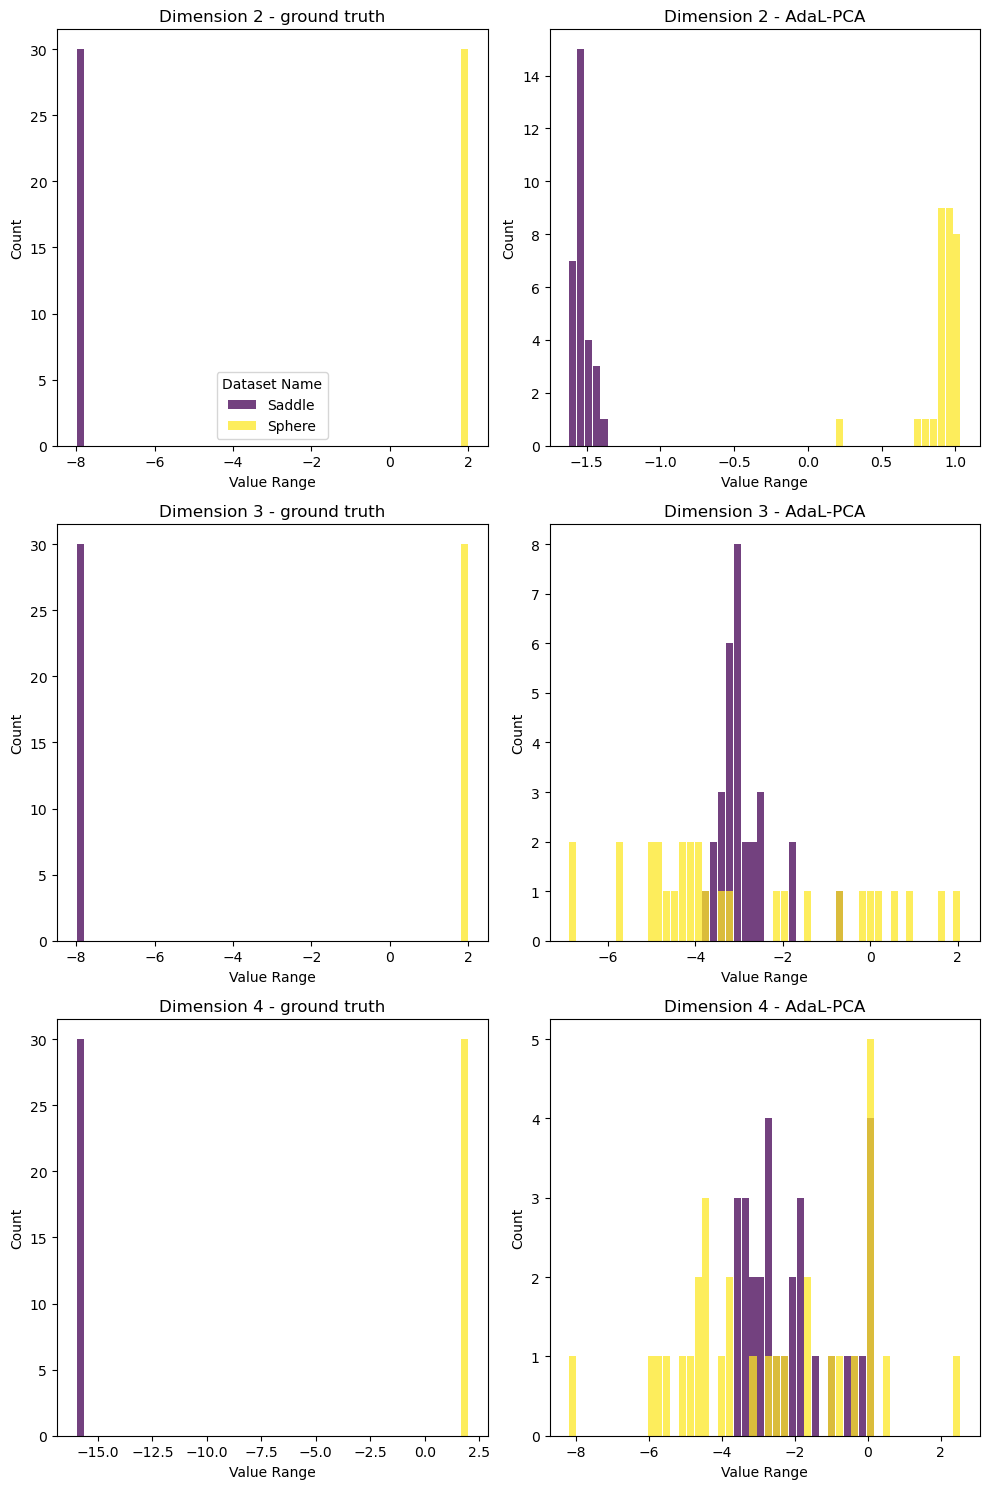

In [ ]:
SS1.plot_by_dimension()

In [ ]:
X

array([[ 0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.6801693 ,  0.33370331,  0.33580606,  0.46403808],
       [ 0.96828954, -0.48549966, -0.2239448 ,  0.75202598],
       ...,
       [-0.41397195,  0.83549737, -0.24954833, -0.46440871],
       [ 0.05777772, -0.55678674, -0.16258285, -0.28024003],
       [-0.49102757,  0.97618481, -0.31278567, -0.61399384]])

In [ ]:
!nbdev_export